
 # Databases

## PETE 2061 Lab 11 (Due on Tuesday by 8 am)

<a id='top'></a>

## Lab 11 (Create your new .ipynb or .py file )
* Using the code given in Lab11_DBnViz.py, write a Python code that loops through all 17 well production rates given. In each iteration of the loop:
    * Insert the Decline curve analysis model parameters into the DCAparams table in the database
    * Insert the actual and model rates and cumulative production into the Rates table in the database
    * Plot and save a figure of the rate and cumulative production vs time (in months).
<br>    

<ipython-input-5-7e08d272cde9>:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  currFig = plt.figure(figsize=(7,5), dpi=100)


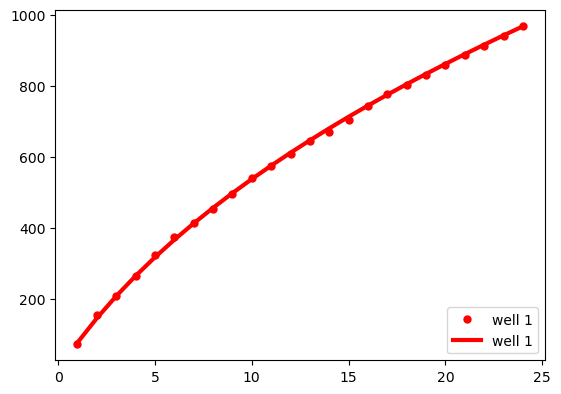

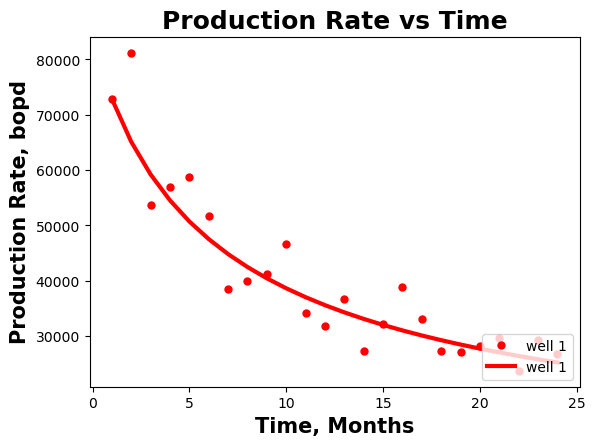

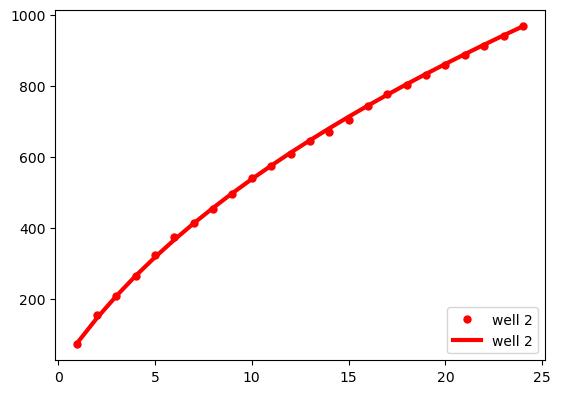

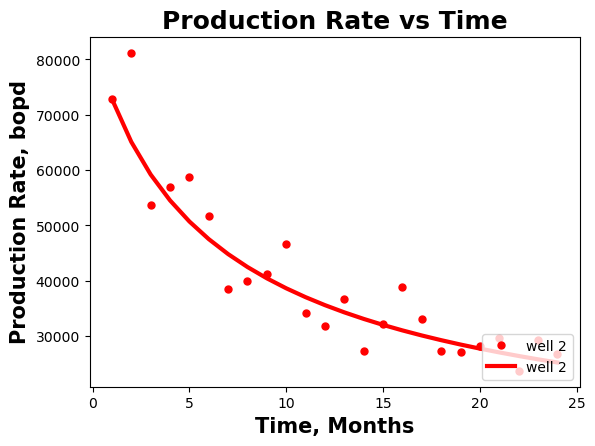

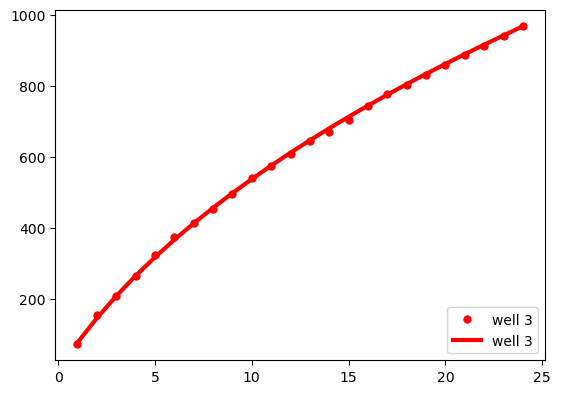

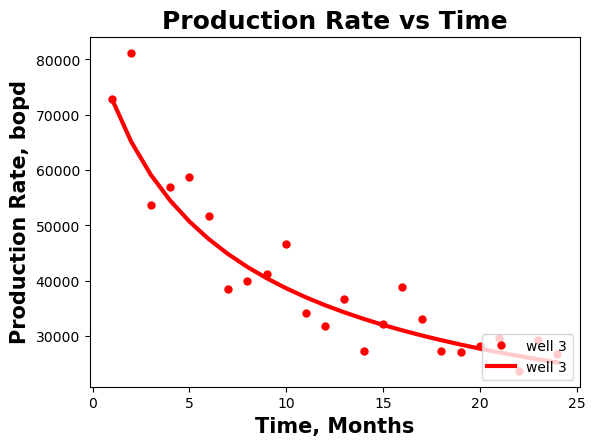

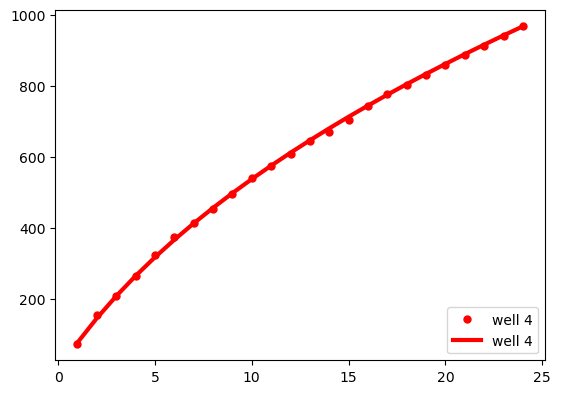

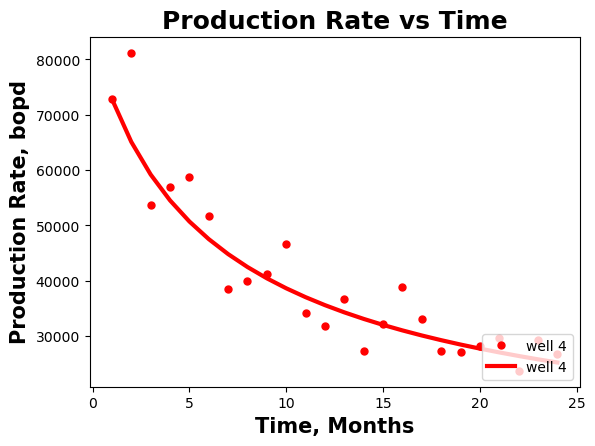

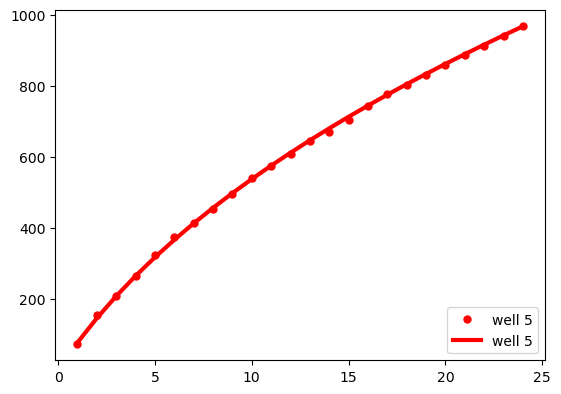

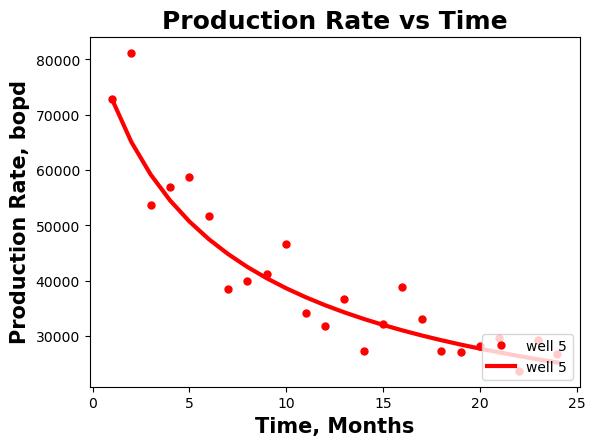

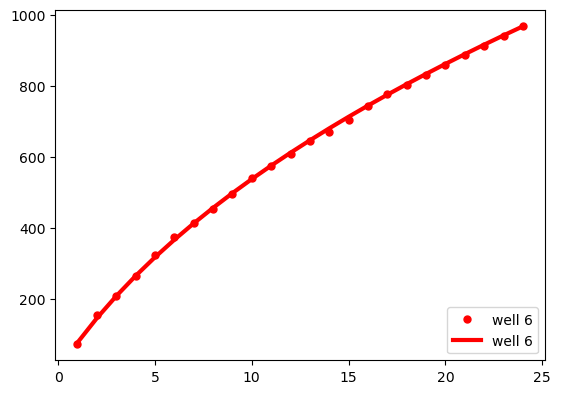

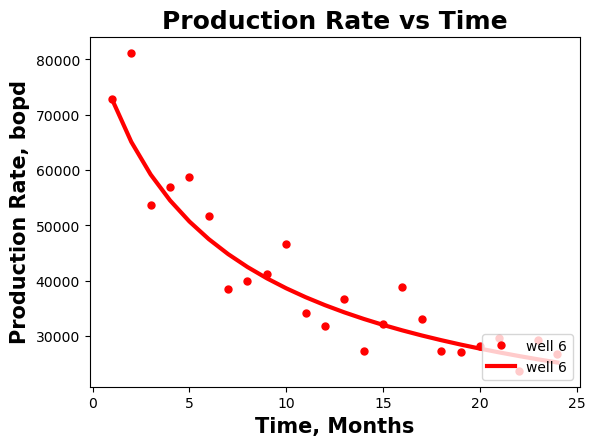

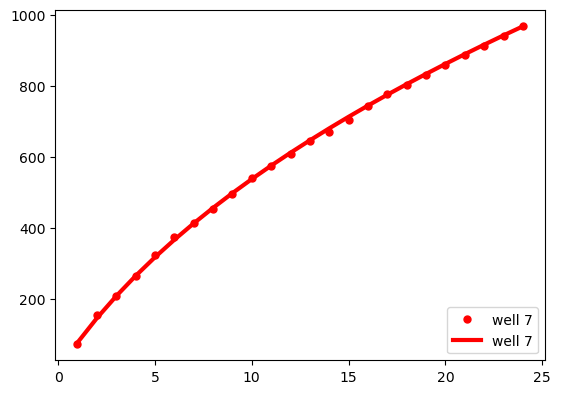

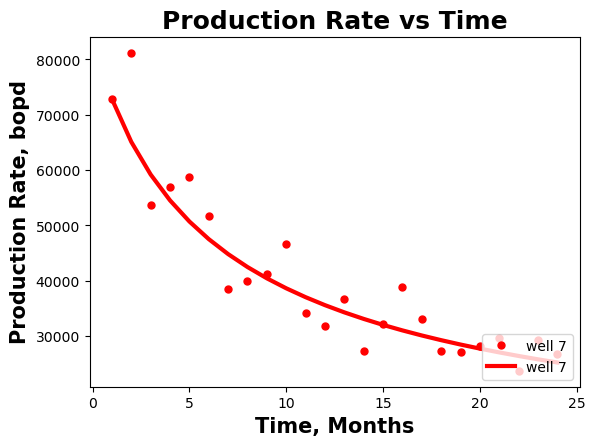

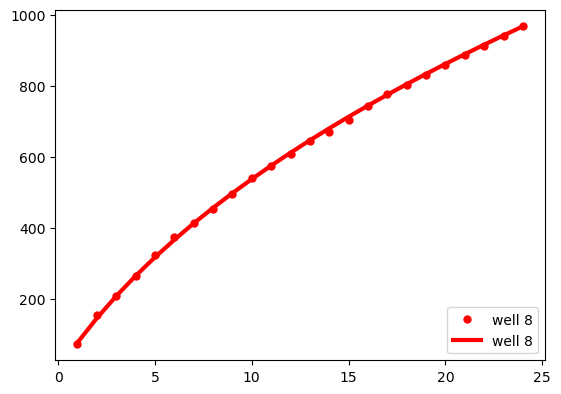

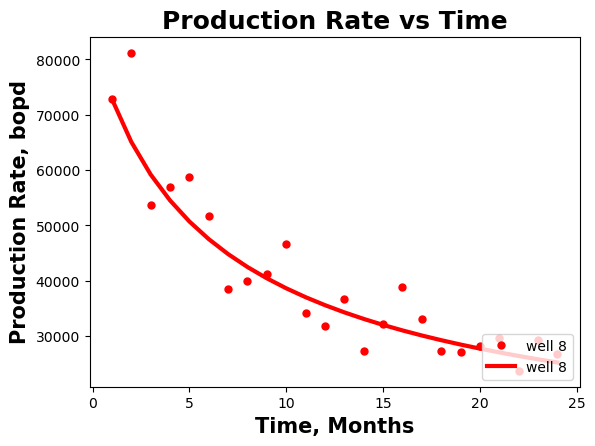

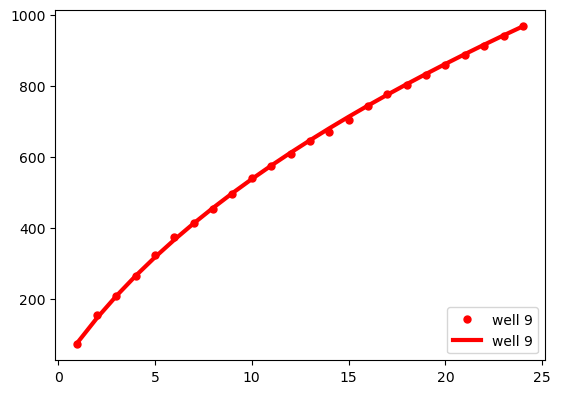

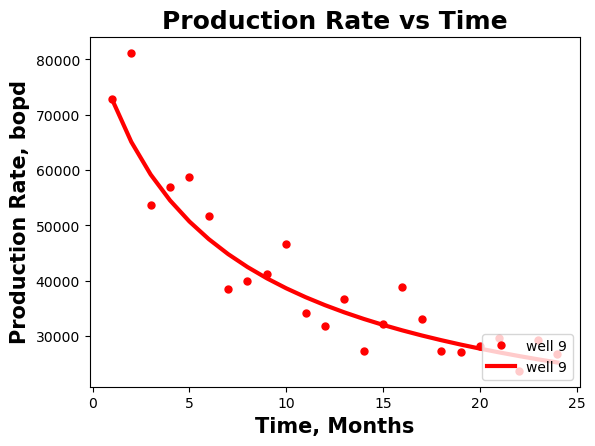

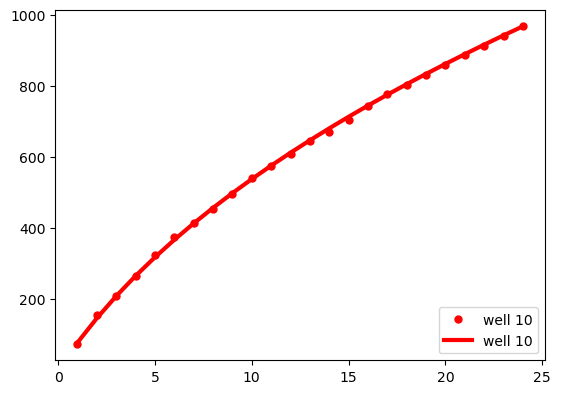

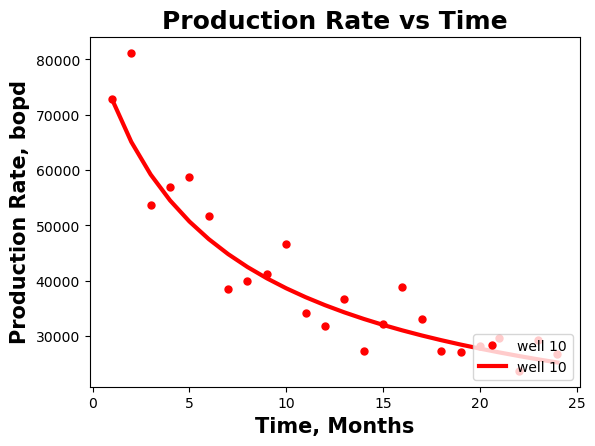

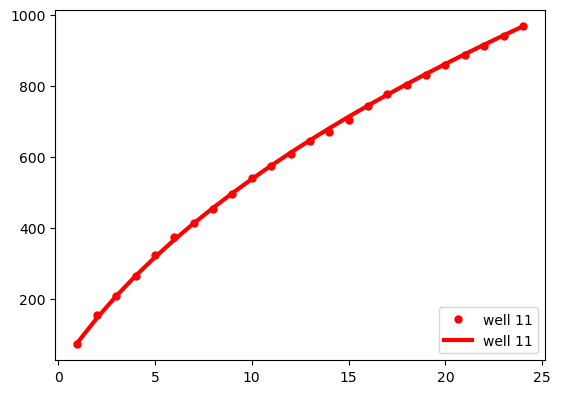

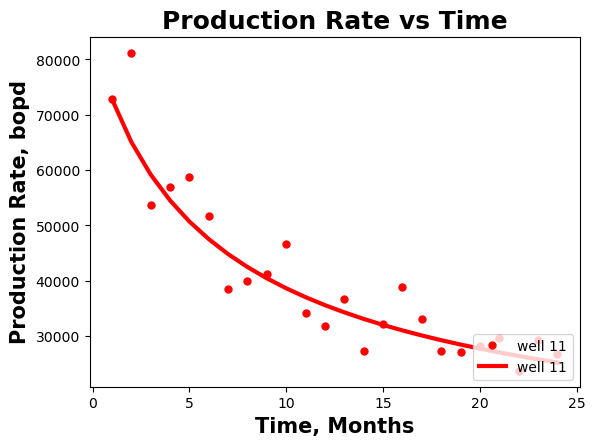

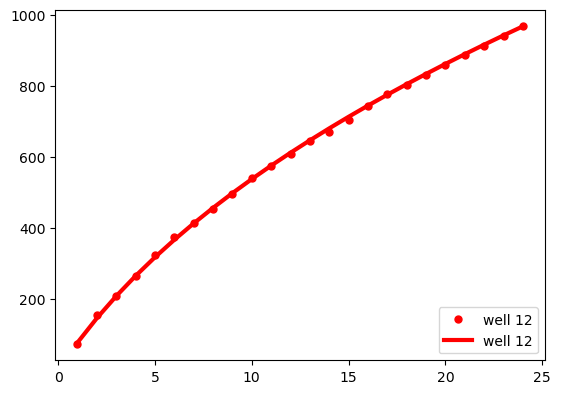

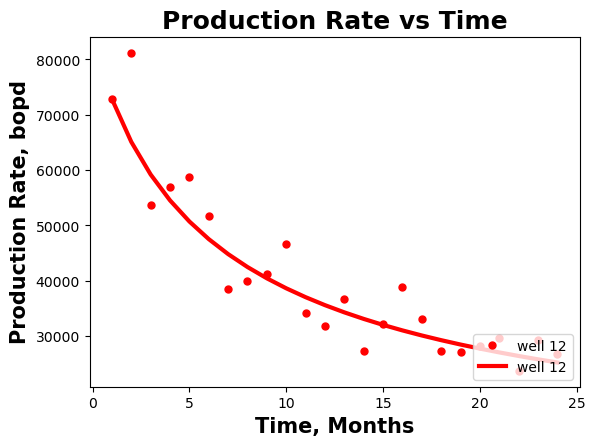

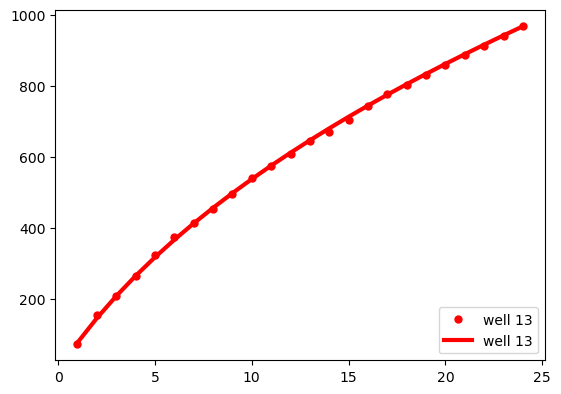

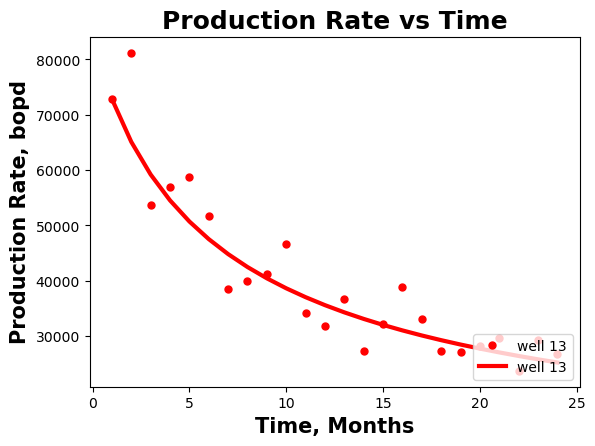

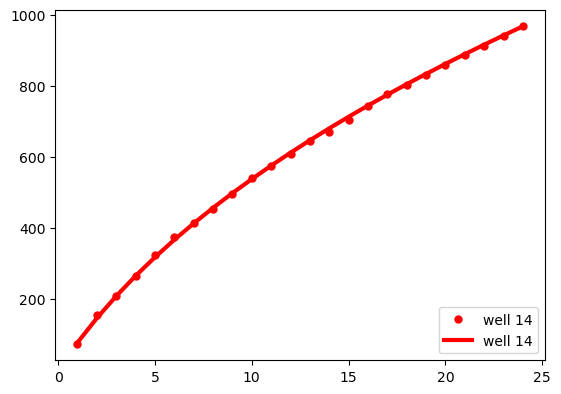

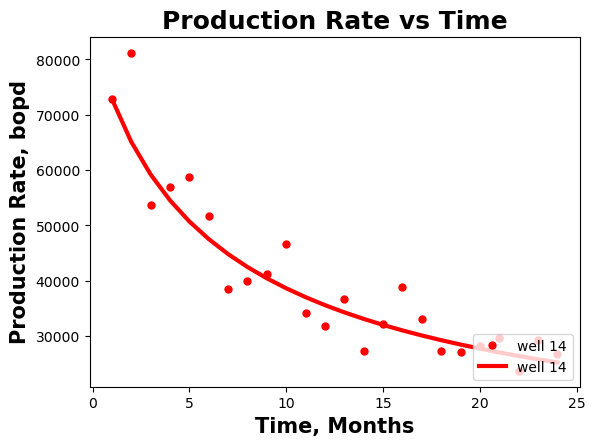

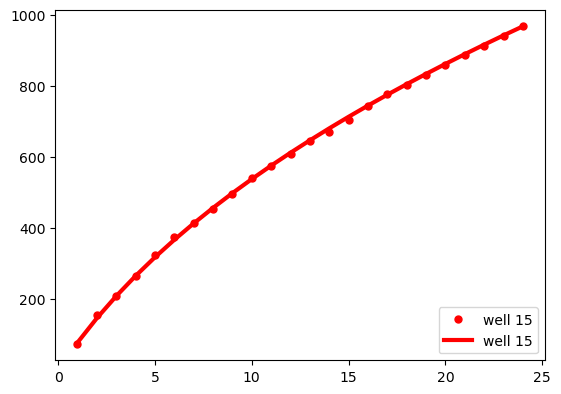

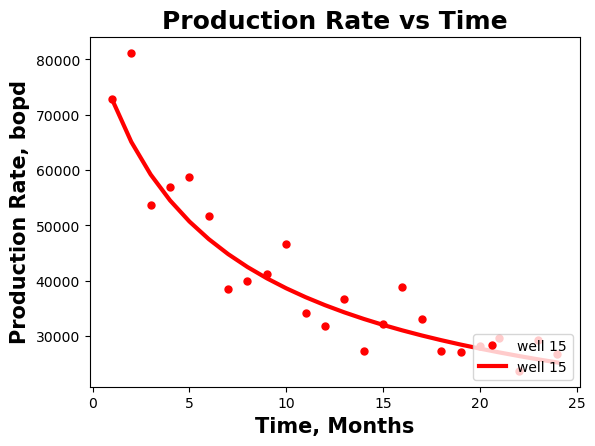

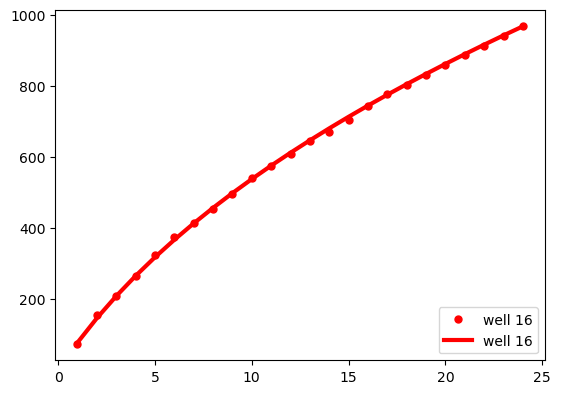

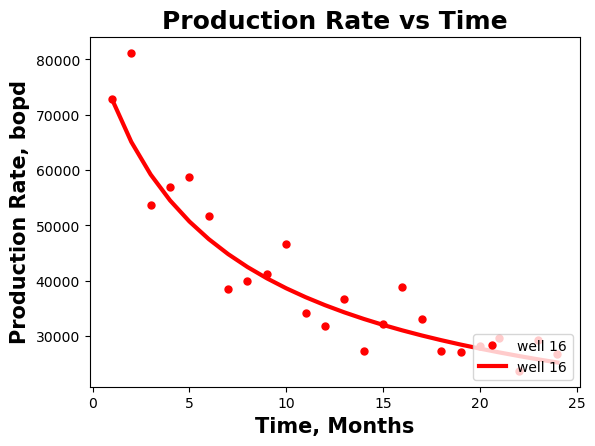

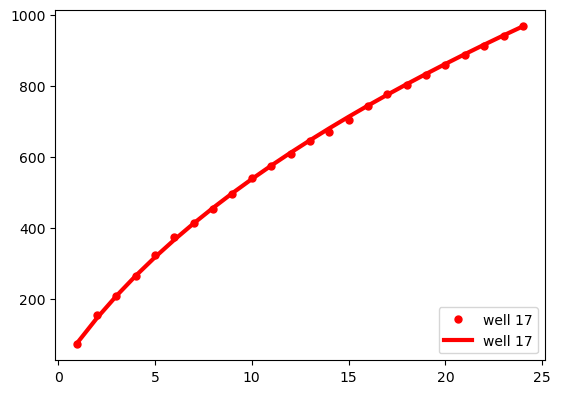

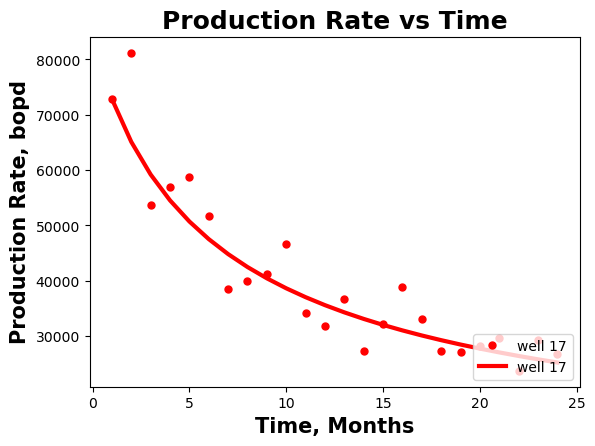

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import sqlite3

#create a database named "DCA.db" in the folder where this code is located
conn = sqlite3.connect("DCA1.db")  #It will only connect to the DB if it already exists

#Create data table to store summary info about each case/well
cur = conn.cursor()   #this creates a connector that is used to talk to send SQL queries
#RUN THIS TO CREATE A NEW TABLE
cur.execute("CREATE TABLE DCAparams1 (wellID INTEGER,  qi REAL, Di REAL, b REAL)")
conn.commit()

dfLength = 24   # this is the number of rows in the production data

titleFontSize=18
axisLabelFontSize=15
axisNumFontSize=13

for wellID in range(1,18):
    # Load spreadsheet
    fileName = 'DCAwells_Solved/DCA_Well ' + str(wellID) + '.xlsx'  

    xl = pd.ExcelFile(fileName)

    # Load Excel tab named "DCARegression" into a DataFrame named df1
    df1 = xl.parse('DCARegression')

    # Create a dataframe with 3 columns-- "wellID", "time", "rate"
    rateDF = pd.DataFrame({'wellID':wellID*np.ones(dfLength,dtype=int), 'time':range(1,dfLength+1),'rate':df1.iloc[8:32,1].values})
    # Compute the cumulative production and store in the fourth column
    rateDF['Cum'] = rateDF['rate'].cumsum()

    # Store qi, Di and b from the "DCARegression" Excel tab
    qi = df1.iloc[2,3]
    Di = df1.iloc[3,3]
    b  = df1.iloc[4,3]

    # Store the wellID, qi, Di, and b into a Database table named DCAparams
    cur.execute(f"INSERT INTO DCAparams1 VALUES ({wellID}, {qi}, {Di}, {b})")
    conn.commit()

    # store time in months (from 1 to 24, as in the "DCARegression" Excel tab)
    t = np.arange(1,dfLength+1)
    Di = Di/12   # convert Di from %/year to %/month

    if b>0:
        # Hyperbolic decline model
        q = 30.4375*qi/((1 + b*Di*t)**(1/b)) #30.4375 = 365.125/12. This is to get rates in bbls/month
        Np = 30.4375*(qi/(Di*(1-b)))*(1-(1/(1+(b*Di*t))**((1-b)/b))) # Also scale Np bcos t is in months
    else:
        # Exponential decline model
        q = qi*np.exp(-Di*t)    # Not scaled yet so that it doesn't mess up our estimation of Np
        Np = 30.4375*(qi-q)/Di 
        q = 30.4375*q           # Now scale q so it becomes in units of bbls/month

    # Compute summ of squares error in the model estimate of rate and cumulative production   
    error_q = rateDF['rate'].values - q
    SSE_q = np.dot(error_q, error_q)  # this is vectorized way to compute sum of squared error

    errorNp = rateDF['Cum'].values - Np
    SSE_Np = np.dot(errorNp, errorNp)

    # Store the model estimates of rate and cumulative production in the "ratesDF" dataframe
    rateDF['q_model'] = q
    rateDF['Cum_model'] = Np

    # Use DataFrame's to_sql() function to put the dataframe into a database table called "Rates"
    rateDF.to_sql("Rates", conn, if_exists="append", index = False)

    # Read from Rates database table using the SQL SELECT statement
    prodDF = pd.read_sql_query("SELECT * FROM Rates WHERE wellID=1;", conn)
    dcaDF=pd.read_sql_query("SELECT * FROM DCAparams1;", conn)

    currFig = plt.figure(figsize=(7,5), dpi=100)

    # Add set of axes to figure
    axes = currFig.add_axes([0.15, 0.15, 0.7, 0.7])# left, bottom, width, height (range 0 to 1)

    # Plot on that set of axes
    axes.plot(prodDF['time'], prodDF['Cum']/1000, color="red", ls='None', marker='o', markersize=5,label = 'well '+str(wellID) )
    axes.plot(prodDF['time'], prodDF['Cum_model']/1000, color="red", lw=3, ls='-',label = 'well '+str(wellID) )
    axes.legend(loc=4)
#    axes.set_ylim([0, 1200])
#    axes.set_xlim([0, 25])
#    xticks = range(0,30,5) #np.linspace(0,4000,5)
#    axes.set_xticks(xticks)
#    axes.set_xticklabels(xticks, fontsize=axisNumFontSize); 

#    yticks = [0, 400, 800, 1200]
#    axes.set_yticks(yticks)
#    axes.set_yticklabels(yticks, fontsize=axisNumFontSize); 

    currFig.savefig('well-'+str(wellID)+'_Gp.png', dpi=600)

    currFig=plt.figure(figsize=(7,5),dpi=100)
    
    # Add set of axes to figure
    axes = currFig.add_axes([0.15, 0.15, 0.7, 0.7])# left, bottom, width, height (range 0 to 1)

    # Plot on that set of axes
    axes.plot(prodDF['time'], prodDF['rate'], color="red", ls='None', marker='o', markersize=5,label = 'well '+str(wellID) )
    axes.plot(prodDF['time'], prodDF['q_model'], color="red", lw=3, ls='-',label = 'well '+str(wellID) )
    axes.legend(loc=4)
    axes.set_title('Production Rate vs Time', fontsize=titleFontSize, fontweight='bold')
    axes.set_xlabel('Time, Months', fontsize=axisLabelFontSize, fontweight='bold') # Notice the use of set_ to begin methods
    axes.set_ylabel('Production Rate, bopd', fontsize=axisLabelFontSize, fontweight='bold')
#    axes.set_ylim([0, 1200])
#    axes.set_xlim([0, 25])
#    xticks = range(0,30,5) #np.linspace(0,4000,5)
#    axes.set_xticks(xticks)
#    axes.set_xticklabels(xticks, fontsize=axisNumFontSize); 

#    yticks = [0, 400, 800, 1200]
#    axes.set_yticks(yticks)
#    axes.set_yticklabels(yticks, fontsize=axisNumFontSize);
    
    currFig.savefig('well-'+str(wellID)+'_q.png', dpi=600)

conn.close()

